# Analyzing Titanic Data with PySpark and SHAP

## I. Setup
To begin we will import all the libraries we need.

In [582]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors

from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import numpy as np
from numpy import array
from time import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap

from pyspark import SparkConf, SparkContext
import findspark
import pyspark
from pyspark.sql import SparkSession

Next let's start our Spark session.

In [583]:
spark = SparkSession \
   .builder \
   .appName("Python Spark SQL basic example") \
   .config("spark.some.config.option", "some-value") \
   .getOrCreate()

Then we can read in our data file. Note that this is the cleaned data from my last project.

In [584]:
df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv("cleaned_titanic_data.csv")

Here's what it looks like, for reference.

In [585]:
df = df.drop('_c0')
df.toPandas().head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_Q,Embarked_C
0,0,3,0,22,1,0,7,1,0,0
1,1,1,1,38,1,0,71,0,0,1
2,1,3,1,26,0,0,7,1,0,0
3,1,1,1,35,1,0,53,1,0,0
4,0,3,0,35,0,0,8,1,0,0


As a reminder, these columns correspond to the following:

* survival = survival | 0 = No, 1 = Yes
* pclass = ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
* sex = sex
* age = age in years
* sibsp = number of siblings / spouses aboard the Titanic
* parch = number of parents / children aboard the Titanic
* fare = passenger fare
* embarked = port of embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

Previously, I cleaned the data and encoded the sex and embarked fields.
Now, sex is encoded to 0 = male, 1 = female. The embarked field was one-hot encoded into three new columns Embarked_S, Embarked_Q, and Embarked_C.

# II. Exploratory Data Analysis

In my last project, I explored the data a bit, but now that I have more experience with Python libraries, we can visualize the data a bit better.

Let's begin by looking at how the data has been cleaned and modified.
This is the starting data. All the pink spots are pieces of missing data.

<AxesSubplot:>

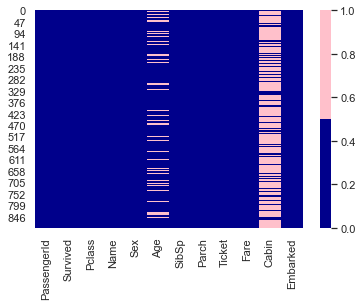

In [586]:
start_data = pd.read_csv("train.csv")
cols = start_data.columns 
colours = ['darkblue', 'pink'] 
sns.heatmap(start_data[cols].isnull(), cmap=sns.color_palette(colours))

And this is the before and after side

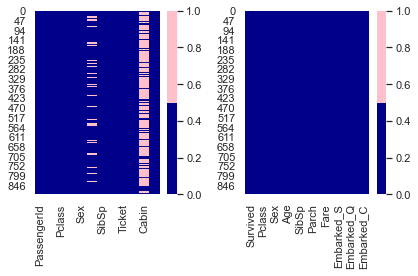

In [587]:
cols = start_data.columns 
colours = ['darkblue', 'pink'] 
new_data = df.toPandas()

# So the data is visualized correctly
new_data["Age"][5] = None

new_cols = new_data.columns

fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(start_data[cols].isnull(), cmap=sns.color_palette(colours), ax = ax1)
sns.heatmap(new_data[new_cols].isnull(), cmap=sns.color_palette(colours), ax = ax2)
fig.tight_layout()

The data now has no missing values!

Next, let's just explore what our dataset looks like for a bit and try to draw some conclusions about what influenced survival.

<AxesSubplot:xlabel='Survived', ylabel='count'>

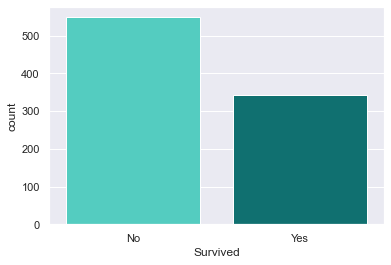

In [588]:
titanic_decoded = df.toPandas()

# Just to make the graphs more digestible, let's decode these fields.
titanic_decoded["Sex"].replace({0:"Male", 1:"Female"}, inplace = True)
titanic_decoded["Survived"].replace({0:"No", 1:"Yes"}, inplace = True)

sns.set_theme(style="darkgrid")
sns.countplot(x='Survived',data=titanic_decoded, palette = ["turquoise", "teal"])

Here's a visualization of the proportion of people that survived vs did not survive.

<AxesSubplot:xlabel='Sex', ylabel='count'>

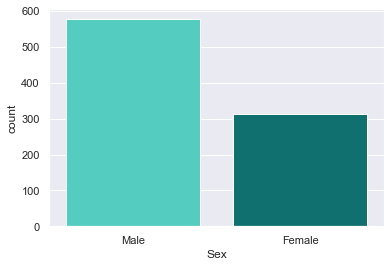

In [589]:
sns.countplot(x='Sex',data=titanic_decoded, palette = ["turquoise", "teal"])

Similarly, here's a visualization of the proportion of males to females on board.

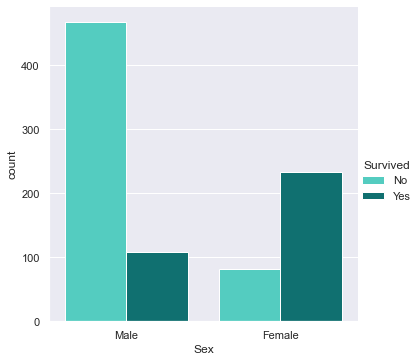

In [590]:
sns.catplot(x ="Sex", hue ="Survived", kind ="count", data = titanic_decoded, palette = ["turquoise", "teal"])

Male vs Female survival rates. Clearly females had a much higher chance of surviving than males did. From this we can hypothesize that sex will play a big role in predicting survival

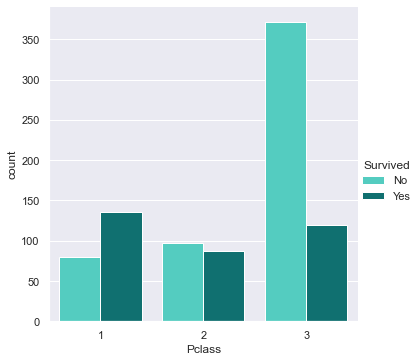

In [591]:
sns.catplot(x ="Pclass", hue ="Survived", kind ="count", data = titanic_decoded, palette = ["turquoise", "teal"])

In this graph, it seems like passenger classes 1 and 2 had a somewhat 50-50 chance of surviving, but people in passenger class 3 had a much lower chance of surviving. This leads us to hypothesizing that passenger class will contribute substancially to predicting survival. Those in pclass 3 are less likely to survive.

<AxesSubplot:xlabel='Sex', ylabel='Age'>

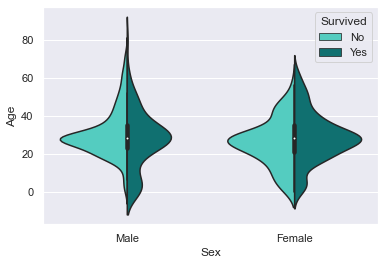

In [592]:
sns.violinplot(x = "Sex", y = "Age", hue = "Survived", data = titanic_decoded, split = True, palette = ["turquoise", "teal"])

Lastly, this is a violin plot of male vs female survival rates along with ages.
This type of graph is very interesting to me, as you can very easily see that children  had a good chance of surviving. From this we can also hypothesize that age plays a big role in predicting survival.

# II. Machine Learning Models

Making machine learning models in Spark is a little more complicated than with SciKit. We first need to convert our dataframe into Labeled Vector (libsvm) format. We can use a VectorAssembler to do that.

In [593]:
df_assembler = VectorAssembler(inputCols=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_S', 'Embarked_Q', 'Embarked_C'], outputCol='features')
df = df_assembler.transform(df)

In [594]:
model_titanic = df.select(['features', 'survived'])
model_titanic.toPandas()

,features,survived
0,"[3.0, 0.0, 22.0, 1.0, 0.0, 7.0, 1.0, 0.0, 0.0]",0
1,"[1.0, 1.0, 38.0, 1.0, 0.0, 71.0, 0.0, 0.0, 1.0]",1
2,"[3.0, 1.0, 26.0, 0.0, 0.0, 7.0, 1.0, 0.0, 0.0]",1
3,"[1.0, 1.0, 35.0, 1.0, 0.0, 53.0, 1.0, 0.0, 0.0]",1
4,"(3.0, 0.0, 35.0, 0.0, 0.0, 8.0, 1.0, 0.0, 0.0)",0
...,...,...
886,"(2.0, 0.0, 27.0, 0.0, 0.0, 13.0, 1.0, 0.0, 0.0)",0
887,"[1.0, 1.0, 19.0, 0.0, 0.0, 30.0, 1.0, 0.0, 0.0]",1
888,"[3.0, 1.0, 28.0, 1.0, 2.0, 23.0, 1.0, 0.0, 0.0]",0
889,"(1.0, 0.0, 26.0, 0.0, 0.0, 30.0, 0.0, 0.0, 1.0)",1


Now that we have our data set up, we can split it into a training and testing set, then train our models.

In [595]:
train_df,test_df = model_titanic.randomSplit([0.75,0.25])

### Decision Tree

We'll start with a decision tree model.

In [596]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='survived')

start_time = time()
dt_model = dt.fit(train_df)
end_time = time()

elapsed_time = round((end_time - start_time), 5)
dt_time = elapsed_time

print("The decision tree took " + str(elapsed_time) + " seconds to train.")

The decision tree took 0.39987 seconds to train.


In [597]:
dt_predictions = dt_model.transform(test_df)

In [598]:
dt_accuracy = round((MulticlassClassificationEvaluator(labelCol='survived',metricName='accuracy').evaluate(dt_predictions) * 100), 5)
dt_precision = round((MulticlassClassificationEvaluator(labelCol='survived',metricName='weightedPrecision').evaluate(dt_predictions) * 100), 5)
print('Accuracy: ' + str(dt_accuracy) + "%")
print('Precision: ' + str(dt_precision) + "%")

Accuracy: 79.5082%
Precision: 79.28431%


In [599]:
survivals = dt_predictions.toPandas()['prediction'].sum()
print("Our model predicted " + str(int(survivals)) + " survivals.")

Our model predicted 83 survivals.


In [600]:
total_predictions = len(dt_predictions.toPandas()['prediction'])
survival_percent = round(((survivals / total_predictions) * 100 ), 3)
print("This is a " + str(survival_percent) + "% survival rate")

This is a 34.016% survival rate


Interestingly, according to https://titanicfacts.net/titanic-survivors
the actual survival rate of all on board passengers was 31.6%. Our model is predicting close to this. Of course the data could be skewed given our random testing sample, but this is pretty cool to me!

### Random Forest Model

Next, lets train a random forest model.

In [601]:
rf = RandomForestClassifier(featuresCol='features', labelCol='survived')

start_time = time()
rf_model = rf.fit(train_df)
end_time = time()

elapsed_time = round((end_time - start_time), 5)
rf_time = elapsed_time

time_difference = round((rf_time - dt_time), 5)

print("The random forest took " + str(elapsed_time) + " seconds to train.")
print("This is " + str(time_difference) + " seconds longer than the decision tree.")


The random forest took 0.47081 seconds to train.
This is 0.07094 seconds longer than the decision tree.


In [602]:
rf_predictions = rf_model.transform(test_df)

In [603]:
rf_accuracy = round((MulticlassClassificationEvaluator(labelCol='survived',metricName='accuracy').evaluate(rf_predictions) * 100), 5)
rf_precision = round((MulticlassClassificationEvaluator(labelCol='survived',metricName='weightedPrecision').evaluate(rf_predictions) * 100), 5)
print('Accuracy: ' + str(rf_accuracy) + "%")
print('Precision: ' + str(rf_precision) + "%")

Accuracy: 81.14754%
Precision: 80.9715%


### Model Comparison

In [604]:
accuracy_difference = rf_accuracy - dt_accuracy
precision_difference = rf_precision - dt_precision

if accuracy_difference > 0:
    print("The random forest was more accurate than the decision tree.")
    print("It was " + str(round(accuracy_difference, 5)) + "% more accurate.")
else: 
    print("The decision tree was more accurate than the random forest.")
    print("It was " + str(round(accuracy_difference, 5) * -1) + "% more accurate.")
    
print()

if precision_difference > 0:
    print("The random forest was more precise than the decision tree.")
    print("It was " + str(round(precision_difference, 5)) + "% more precise.")
else: 
    print("The decision tree was more precise than the random forest.")
    print("It was " + str(round(precision_difference, 5) * -1) + "% more precise.")

The random forest was more accurate than the decision tree.
It was 1.63934% more accurate.

The random forest was more precise than the decision tree.
It was 1.68719% more precise.


# III. SHAP Analysis

Lastly, let's try to get a better understanding of what the most important features are for predicting survival by doing a SHAP analysis. SHAP aims to demystify machine learning models by increasing their understandability.

In [605]:
df = df.toPandas()
target = df.Survived.values
df = df.drop(columns=["Survived", "features"])

Let's create a new SciKit random forest model and train it with our data.

In [606]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=0)
random_forest = skRandomForestClassifier(n_estimators=100, random_state = 0)

start_time = time()
random_forest.fit(x_train, y_train)
end_time = time()
elapsed_time = round((end_time - start_time), 5)
skrf_time = elapsed_time
random_forest_preds = random_forest.predict(x_test)

skrf_accuracy = round(((metrics.accuracy_score(random_forest_preds,y_test))* 100), 5)
print('The accuracy of the Random Forest model is: ' + str(skrf_accuracy) + "%")

The accuracy of the Random Forest model is: 84.9162%


### Force Graphs

Now we can analyze it using SHAP. To do this, we first need to create an explainer that will "understand" our model works.

In [607]:
explainer = shap.TreeExplainer(random_forest, x_train)
shap_values = explainer.shap_values(x_test)

Then we can use it to start making graphs. Let see a force graph.

In [608]:
shap.force_plot(explainer.expected_value[0], shap_values[1], x_test)

Here's the overall SHAP force graph of all the data. This graph can look quite confusing and took me a while to understand, so let's look at some smaller graphs to figure out what this is showing us and how we can use it to learn more about our model.

Let's begin by looking at a single person's shap values. Here are their characteristics

In [609]:
person = x_test.loc[[8]]
person

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_Q,Embarked_C
8,3,1,27,0,2,11,1,0,0


Then we can look at their shap force graph.

In [610]:
person_shap_values = explainer.shap_values(person)
shap.initjs()
shap.force_plot(explainer.expected_value[1], person_shap_values[1], person)

This graph can be a bit confusing too, so let's break it down.
* The bold number 0.62 is the model's output for this person. 
* The number labels are a range of values around the outputs for all people in this model.
* The bars in red and blue are characteristics of the person being evaluated.
* Characteristics in red push the model's output higher, and blue pushes it lower.
* The grey "base value" (0.3623) is the average of all output values of the model.

With this in mind, it's easier to understand how the model came to it's output value. Here, the biggest contributing factors to the model's output were this person's sex, age, and passenger class. Being a women and being 27 make this person more likel to survive, while being in passenger class 3 makes the person less likely to survive.

Let's visualize this a different way with a waterfall plot.

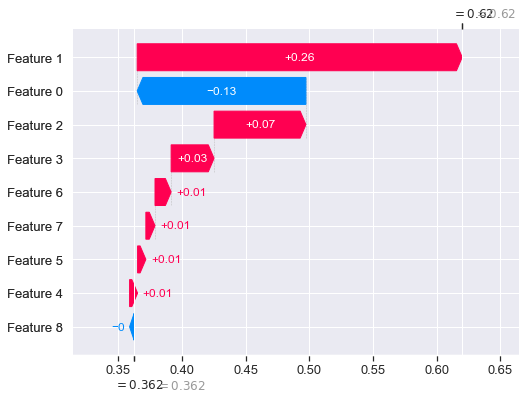

In [611]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], person_shap_values[1][0])

Here we can easily see how each of the characteristics sums up to give us the final model output. We start at the bottom of the plot at the expected value of the model output and as we move up, we see how each feature influences the output.

With this in mind, we can take another look at the plot from before and try to understand it.

In [612]:
shap.force_plot(explainer.expected_value[0], shap_values[1], x_test)

As we scroll across the graph, we see a bold number on the left axis. This is the model's output. We can also see the important features contributing to that person's model output. This is actually a combination of all the individual peoples' force graphs stacked together vertically!

If we order by output value, we can see that instances with higher model outputs have many more red features that the model thinks makes them more likely to survive than blue features that reduces their chances to survive, and vice versa for instances with low model outputs.

Now, an common observation would be: but wait, when we scroll through this graph, hardly any of the output values here are 0 or 1. This is a classification problem, so what does that mean? I was confused on this for a while too, and thought that my model was messed up. After a bit of research, I learned that this was intentional.

The model output isn't actually it's final prediction. The value that we get as an output is transformed into probability space, which the model uses to make a prediction.

### Important Features

So, with these things in mind, what are the most important features in this dataset?

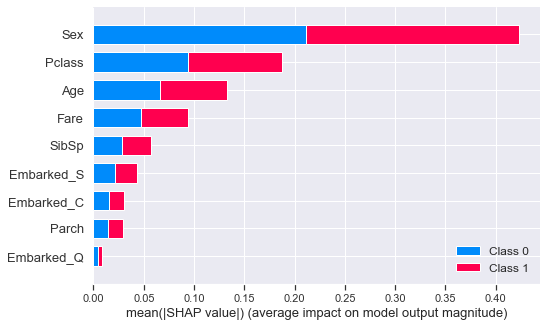

In [613]:
shap.summary_plot(shap_values, x_train)

We can see that sex, pclass, and age were the most important features for predicting survival.

Lastly, let's look at a beeswarm graph to understand exactly how each feature contributes to survival prediction.

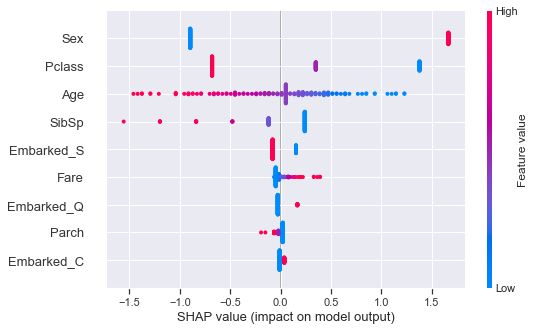

In [614]:
# New model because beeswarm graph isn't working with my random forest model.
LR = LogisticRegression(max_iter = 1000)
LR.fit(x_train, y_train)
explainer = shap.LinearExplainer(LR, x_train)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

This graph shows us some interesting things. The color of each point represents whether it was high or low in the actual data set. It's distance left or right represents its impact on the model output - farther right means the model was more likely to predict survival and the opposite the left side. Note that some features have continuous spreads while others are fragmented. This is because features like age could have a large range of values, while features like sex could only have two values - 0 or 1.

Some simple observations we can make are:
* Being a female made you much more likely to survive. 
* The lower your passenger class, the more likely you were to survive.
* The younger you are, the more likely you were to survive.
* The more siblings you had, the less likely you were to survive.

# IV. Conclusions

### SciKit VS PySpark

Now that we have run both SciKit and PySpark models, we can compare them.

In [615]:
print("The time to train the decision tree with PySpark was " + str(dt_time))
print("The time to train the random forest with PySpark was " + str(rf_time))
print("The time to train the random forest with SciKit was " + str(skrf_time))

The time to train the decision tree with PySpark was 0.39987
The time to train the random forest with PySpark was 0.47081
The time to train the random forest with SciKit was 0.13368


Interestingly, the SciKit model was faster than both the PySpark ones. Perhaps this could be because we are using a small dataset. SciKit models may be faster for small datasets, but for very large ones, Spark would likely be faster.

In [616]:
print("The accuracy of the decision tree with PySpark was " + str(dt_accuracy))
print("The accuracy of the random with PySpark was " + str(rf_accuracy))
print("The accuracy of the random forest with SciKit " + str(skrf_accuracy))

The accuracy of the decision tree with PySpark was 79.5082
The accuracy of the random with PySpark was 81.14754
The accuracy of the random forest with SciKit 84.9162


### Conclusion
* SciKit actually out performed PySpark overall.
* The most important features for predicting survival were Sex, Passenger Class, and Age, as we hypothesized.

### Challenges
* Setting up the environment to run Spark and SHAP was difficult.
* Getting used to using Spark was quite confusing. Data had to be transformed from a csv to libsvm format, which took a while to figure out. Additionally, I was had a lot of trouble getting my models working correctly.
* Some of my SHAP graphs weren't displaying properly which took a while to debug.

### Improvements
* Try to do feature engineering / hyperparameter tuning in PySpark.
* Try to do a SHAP analysis on my PySpark models.